### Boost Model Accuracy of Imbalanced COVID-19 Mortality Prediction Using GAN-based Oversampling Technique.   

The data and the core model for this article are considered from the recent study (July 2020) on “COVID-19 Patient Health Prediction Using Boosted Random Forest Algorithm” by Celestine Iwendi, Ali Kashif Bashir, Atharva Peshkar. et al. This study used the Random Forest algorithm boosted by the AdaBoost model and predicted the mortality of individual patients with 94% accuracy. In this article, the same model and model parameters were considered to clearly analyze the improvement of existing model accuracies by using GAN- based Oversampling Technique.

The data used in studies were trained using 222 patient records with 13 features. The data is biased as 159(72%) cases belong to the class `0′ or ‘recovered’. Due to its skewed nature, various undersampling/oversampling techniques can be applied to the data. The problem of skewness data could lead to overfitting of the prediction model. To overcome this limitation many studies have implemented the use of oversampling methods to provide a balance to the dataset, leading to more accurate model training. Oversampling is a technique for compensating the imbalance of a dataset, by increasing the number of samples within the minority data. Conventional methods include Random Oversampling (ROS), Synthetic Minority Oversampling Technique (SMOTE) and others can be applied. [Credit](https://www.analyticsvidhya.com/blog/2020/10/lets-improve-the-model-accuracy-of-imbalanced-covid-19-mortality-prediction-using-generative-adversarial-networks-gan-based-oversampling-technique/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A+AnalyticsVidhya+%28Analytics+Vidhya%29)

Recently, a machine learning model for developing a generative network based on an adversarial learning concept, namely the Generative Adversarial Networks (GAN), has been proposed. The characteristic of Generative Adversarial Networks (GAN) makes it easily applicable to oversampling studies since the nature of the neural network developed based on adversarial training allows artificial data to be made that is similar to the original data. Oversampling based on Generative Adversarial Networks (GAN) overcomes the limitations of conventional methods, such as overfitting, and allows the development of a highly accurate prediction model of imbalanced data.

**How GAN generate synthetic data?**

Two neural networks compete against each other to learn the target distribution and generate artificial data

A generator network G: mimic training samples to fool the discriminator

A discriminator network D: discriminate training samples and generated samples



Generative adversarial networks are based on a game-theoretic scenario in which the generator network must compete against an adversary.  As GAN learns to mimic the distribution of data, 

In [25]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf  
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding  
from keras.layers.advanced_activations import LeakyReLU  
from keras.layers.merge import concatenate  
from keras.models import Sequential, Model  
from keras.optimizers import Adam  
from keras.utils import to_categorical  
from keras.layers.advanced_activations import LeakyReLU  
from keras.utils.vis_utils import plot_model  
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder  

In [2]:
import scipy.stats  
import datetime as dt  
import pydot  
import warnings  
warnings.filterwarnings("ignore")  
%matplotlib inline  


In [7]:
df = pd.read_csv('./Downloads/data/Covid_data.csv')  
df = df.drop('id',axis=1)  
df = df.fillna(np.nan,axis=0)  
df['age'] = df['age'].fillna(value=df['age'].mean())  

In [8]:
df.head()

location country  gender   age     sym_on   hosp_vis  vis_wuhan  \
0  Shenzhen, Guangdong   China    male  66.0   1/3/2020  1/11/2020          1   
1             Shanghai   China  female  56.0  1/15/2020  1/15/2020          0   
2             Zhejiang   China    male  46.0   1/4/2020  1/17/2020          0   
3              Tianjin   China  female  60.0        NaN        NaN          1   
4              Tianjin   China    male  58.0        NaN        NaN          0   

   from_wuhan  death  recov symptom1 symptom2 symptom3 symptom4 symptom5  \
0         0.0      0      0      NaN      NaN      NaN      NaN      NaN   
1         1.0      0      0      NaN      NaN      NaN      NaN      NaN   
2         1.0      0      0      NaN      NaN      NaN      NaN      NaN   
3         0.0      0      0      NaN      NaN      NaN      NaN      NaN   
4         0.0      0      0      NaN      NaN      NaN      NaN      NaN   

  symptom6  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [ ]:
df['sym_on'] = pd.to_datetime(df['sym_on'])  
df['hosp_vis'] = pd.to_datetime(df['hosp_vis'])  
df['sym_on']= df['sym_on'].map(dt.datetime.toordinal)  
df['hosp_vis']= df['hosp_vis'].map(dt.datetime.toordinal)  
df['diff_sym_hos']= df['hosp_vis'] - df['sym_on']  
df=df.drop(['sym_on', 'hosp_vis'], axis=1)  

In [9]:
df['location'] = df['location'].astype(str)  
df['country'] = df['country'].astype(str)  
df['gender'] = df['gender'].astype(str)  
df['vis_wuhan'] = df['vis_wuhan'].astype(str)  
df['from_wuhan'] = df['from_wuhan'].astype(str)  
df['symptom1'] = df['symptom1'].astype(str)  
df['symptom2'] = df['symptom2'].astype(str)  
df['symptom3'] = df['symptom3'].astype(str)  
df['symptom4'] = df['symptom4'].astype(str)  
df['symptom5'] = df['symptom5'].astype(str)  
df['symptom6'] = df['symptom6'].astype(str)  
df.dtypes

location         object
country          object
gender           object
age             float64
vis_wuhan        object
from_wuhan       object
death             int64
recov             int64
symptom1         object
symptom2         object
symptom3         object
symptom4         object
symptom5         object
symptom6         object
diff_sym_hos      int64
dtype: object

# Visualization

In [14]:
import matplotlib.pyplot as plt
def counter2(colname1,colname2):
    colname1 = pd.Series(colname1)
    colname2 = pd.Series(colname2)
    count1 = 0
    for i in range(min([colname1.size,colname2.size])):
        if(colname1[i]==1 and colname2[i]==1):
            count1 = count1+1
    return count1

def counter1(colname):
    colname1 = pd.Series(colname)
    count = 0
    for i in range(colname1.size):
        if(colname1[i]==1):
            count = count+1
    return count

In [16]:
fwuh = counter1(df['from_wuhan'])
vwuh = counter1(df['vis_wuhan'])

In [18]:
print(counter1(df['death']))
print(counter2(df['from_wuhan'],df['death']))
print(counter2(df['vis_wuhan'],df['death']))

63
0
0


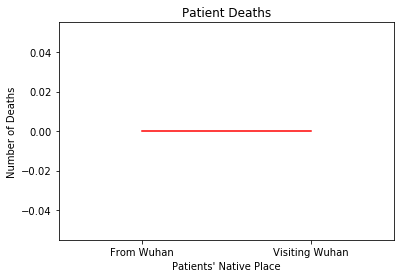

In [20]:
plt.bar(['From Wuhan','Visiting Wuhan'],[counter2(df['death'],df['from_wuhan']),counter2(df['death'],df['vis_wuhan'])],color='green')
plt.title('Patient Deaths')
plt.xlabel('Patients\' Native Place')
plt.ylabel('Number of Deaths')
plt.plot([counter2(df['death'],df['from_wuhan']),counter2(df['death'],df['vis_wuhan'])],color='red')
plt.show()

In [22]:

df = pd.read_csv('./Downloads/data/covid_train.csv') 
print(df.head())

   id      location country gender   age      sym_on    hosp_vis  vis_wuhan  \
0  49  Wuhan, Hubei   China   male  61.0  12/20/2019  12/27/2019          0   
1  50  Wuhan, Hubei   China   male  69.0  12/30/2019    1/3/2020          0   
2  51  Wuhan, Hubei   China   male  89.0         NaN         NaN          0   
3  52  Wuhan, Hubei   China   male  89.0   1/13/2020   1/13/2020          0   
4  53  Wuhan, Hubei   China   male  66.0   1/10/2020   1/16/2020          0   

   from_wuhan  death symptom1 symptom2 symptom3  symptom4  symptom5  symptom6  
0           1      1      NaN      NaN      NaN       NaN       NaN       NaN  
1           1      1      NaN      NaN      NaN       NaN       NaN       NaN  
2           1      1      NaN      NaN      NaN       NaN       NaN       NaN  
3           1      1      NaN      NaN      NaN       NaN       NaN       NaN  
4           1      1      NaN      NaN      NaN       NaN       NaN       NaN  


In [29]:
df = df.fillna(np.nan,axis=0)
df['age'] = df['age'].fillna(value=df['age'].mean())
df['location'] = LabelEncoder().fit_transform(df['location'].astype(str))
df['country'] = LabelEncoder().fit_transform(df['country'].astype(str))
df['gender'] = LabelEncoder().fit_transform(df['gender'].astype(str))
df[['symptom1']] = LabelEncoder().fit_transform(df['symptom1'].astype(str))
df[['symptom2']] = LabelEncoder().fit_transform(df['symptom2'].astype(str))
df[['symptom3']] = LabelEncoder().fit_transform(df['symptom3'].astype(str))
df[['symptom4']] = LabelEncoder().fit_transform(df['symptom4'].astype(str))
df[['symptom5']] = LabelEncoder().fit_transform(df['symptom5'].astype(str))
df[['symptom6']] = LabelEncoder().fit_transform(df['symptom6'].astype(str))